# Text Analysis and Sentiment Scoring Project

## Project Overview
This project analyzes articles from Black Coffer's website to determine various text metrics including:
- Sentiment (positive/negative) scores
- Readability metrics (Fog Index, average sentence length)
- Text complexity metrics (percentage of complex words)

The analysis follows these steps:
1. Web scraping articles from provided URLs
2. Text preprocessing and cleaning
3. Calculating various text metrics
4. Analyzing and visualizing the results
5. Exporting results to Excel

## Requirements
- pandas, numpy, matplotlib, seaborn
- BeautifulSoup, requests
- NLTK
- fake_useragent
- tqdm (for progress tracking)

## Methods
The analysis uses various NLP techniques including tokenization, sentiment analysis 
based on positive/negative word dictionaries, and readability formulas.


In [20]:
import os
import numpy as np 
import pandas as pd
import re 
import requests
import matplotlib.pyplot as plt
import seaborn as sns
from nltk.tokenize import RegexpTokenizer, sent_tokenize
from bs4 import BeautifulSoup 
from fake_useragent import UserAgent
import time
from tqdm import tqdm

In [21]:
# Set plot styling
plt.style.use('ggplot')
sns.set_theme(font_scale=1.2)

In [22]:
#Loading all files in the code
BASE_DIR = 'D:\\Portfolio_project\\BlackCofer'
STOP_WORDS_FILE = os.path.join(BASE_DIR, 'StopWords_Generic.txt')
POSITIVE_WORDS_FILE = os.path.join(BASE_DIR, 'positive-words.txt')
NEGATIVE_WORDS_FILE = os.path.join(BASE_DIR, 'negative-words.txt')
INPUT_FILE = os.path.join(BASE_DIR, 'Input.xlsx')


In [23]:
try:
    input_df = pd.read_excel(INPUT_FILE)
    print(f"Successfully loaded input file with {len(input_df)} articles")
except FileNotFoundError:
    print(f"Error: Input file not found at {INPUT_FILE}")
    input_file_path = input("Please provide the correct path to Input.xlsx: ")
    input_df = pd.read_excel(input_file_path)

Successfully loaded input file with 114 articles


In [24]:
def get_article_names(urls):
    """
    Extract article names from URLs by cleaning the URL path.  
    """
    titles = []
    for i in range(len(urls)):
        try:
            title = urls[i]
            title_clean = title[title.index("m/") + 2:-1].replace('-', ' ')
            titles.append(title_clean)
        except (ValueError, IndexError):
            # Handle URLs with unexpected format
            titles.append(f"Article {i+1}")
    return titles

In [25]:
urls = input_df["URL"]
urlsTitleDF = get_article_names(urls)

In [26]:
def load_word_lists():
    """
    Load positive words, negative words, and stop words from files.
    """
    try:
        # Loading positive words
        with open(POSITIVE_WORDS_FILE, 'r') as posfile:
            positivewords = posfile.read().lower()
        positiveWordList = positivewords.split('\n')
        
        # Loading negative words
        with open(NEGATIVE_WORDS_FILE, 'r', encoding="ISO-8859-1") as negfile:
            negativeword = negfile.read().lower()
        negativeWordList = negativeword.split('\n')
        
        # Loading stop words dictionary for removing stop words
        with open(STOP_WORDS_FILE, 'r') as stop_words:
            stopWords = stop_words.read().lower()
        stopWordList = stopWords.split('\n')
        stopWordList[-1:] = []
        
        print(f"Loaded {len(positiveWordList)} positive words")
        print(f"Loaded {len(negativeWordList)} negative words")
        print(f"Loaded {len(stopWordList)} stop words")
        
        return positiveWordList, negativeWordList, stopWordList
    except FileNotFoundError as e:
        print(f"Error loading word lists: {e}")
        raise

In [27]:
# Load the word lists
positiveWordList, negativeWordList, stopWordList = load_word_lists()

Loaded 2007 positive words
Loaded 4784 negative words
Loaded 120 stop words


In [28]:
# Tokenizes the input text by removing stop words and returns the filtered words
def tokenizer(text):
    if not isinstance(text, str):
        return []
    text = text.lower()  # convert to lowercase
    tokenizer = RegexpTokenizer(r'\w+')  # create a tokenizer object
    tokens = tokenizer.tokenize(text)  # tokenize the input text
    filtered_words = [token for token in tokens if token not in stopWordList]  # remove stop words from the tokens
    return filtered_words

In [29]:
# Calculates the number of positive words in the input text
def positive_score(text):
    token_phrase = tokenizer(text)  # tokenize the input text
    pos_word_count = sum([1 for word in token_phrase if word in positiveWordList])  # count the number of positive words
    return pos_word_count

In [30]:
# Calculates the number of negative words in the input text
def negative_score(text):
    token_phrase = tokenizer(text)  # tokenize the input text
    neg_word_count = sum([1 for word in token_phrase if word in negativeWordList])  # count the number of negative words
    return neg_word_count

In [31]:
# Calculates the polarity score of the input text
def polarity_score(positive_score, negative_score):
    return (positive_score - negative_score) / ((positive_score + negative_score) + 0.000001)

In [32]:
def total_word_count(text):
    tokens = tokenizer(text)  # tokenize the input text
    return len(tokens)

In [33]:
def average_sentence_length(text):
    """
    Calculate the average sentence length.
    """
    if not isinstance(text, str) or not text.strip():
        return 0
    word_count = len(tokenizer(text))  # count the total number of words in the input text
    sentence_count = len(sent_tokenize(text))  # count the total number of sentences in the input text
    if sentence_count > 0:
        average_sentence_length = word_count / sentence_count  # calculate average sentence length
        return round(average_sentence_length)
    return 0

In [34]:
def complex_word_count(text):
    """
    Count complex words based on vowel patterns and suffixes.
    """
    tokens = tokenizer(text)  # tokenize the input text
    complex_word_count = sum([1 for word in tokens if len(re.findall(r'[aeiou]{3,}', word)) > 0 and not (word.endswith(('es', 'ed')))])  # count complex words based on vowel count and suffixes
    return complex_word_count

In [35]:
# Returns the percentage of complex words in the input text
def percentage_complex_word(text):
    """
    Calculate the percentage of complex words.
    """
    tokens = tokenizer(text)  # tokenize the input text
    complex_words = sum([1 for word in tokens if len(re.findall(r'[aeiou]{3,}', word)) > 0 and not (word.endswith(('es', 'ed')))])  # count complex words based on vowel count and suffixes
    total_words = len(tokens)  # count total number of words
    
    if total_words > 0:
        percentage_complex = (complex_words / total_words) * 100  # calculate percentage of complex words
        return round(percentage_complex, 2)
    return 0

In [36]:
def fog_index(averageSentenceLength, percentageComplexWord):
    """
    Calculate the Fog Index for readability.
    """
    fogIndex = 0.4 * (averageSentenceLength + percentageComplexWord)
    return round(fogIndex, 2)

In [37]:
# Scrape article content with error handling and retries
def scrape_articles(urls, max_retries=3, delay=1):
    """
    Scrape article content from a list of URLs with error handling and retries.
    
    Args:
        urls (list): List of article URLs
        max_retries (int): Maximum number of retries for failed requests
        delay (int): Delay between requests in seconds
        
    Returns:
        list: List of article texts
    """
    corps = []
    ua = UserAgent()
    
    for url in tqdm(urls, desc="Scraping articles"):
        retries = 0
        while retries < max_retries:
            try:
                headers = {"User-Agent": ua.random}
                response = requests.get(url, headers=headers, timeout=10)
                response.raise_for_status()  # Raise an exception for 4XX/5XX responses
                
                soup = BeautifulSoup(response.content, "html.parser")
                
                # Get the title of the article, or an empty string if it doesn't exist
                title_element = soup.select_one(".entry-title")
                title = title_element.text if title_element is not None else ""
                
                # Get the text of the article, or an empty string if it doesn't exist
                text_element = soup.select_one(".td-post-content")
                text = text_element.text if text_element is not None else ""
                
                # Split the text into lines and remove leading and trailing whitespace
                lines = (line.strip() for line in text.splitlines()) if text is not None else []
                
                # Split multi-headlines into a line each
                chunks = [phrase.strip() for line in lines for phrase in line.split("  ")]
                
                # Drop blank lines
                text = "\n".join(chunk for chunk in chunks if chunk)
                
                corps.append(text)
                time.sleep(delay)  # Be respectful with scraping
                break  # Break the retry loop if successful
                
            except (requests.RequestException, Exception) as e:
                retries += 1
                print(f"Error scraping {url}: {e}. Retry {retries}/{max_retries}")
                time.sleep(delay * 2)  # Wait longer between retries
                
                if retries == max_retries:
                    print(f"Failed to scrape {url} after {max_retries} attempts.")
                    corps.append("")  # Add empty text for failed scrapes
        
    return corps

In [38]:
# Scrape the articles
print("Starting article scraping...")
corps = scrape_articles(urls)
print(f"Scraped {len(corps)} articles")

Starting article scraping...


Scraping articles:  21%|██        | 24/114 [01:32<05:22,  3.59s/it]

Error scraping https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/: 404 Client Error: Not Found for url: https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/. Retry 1/3
Error scraping https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/: 404 Client Error: Not Found for url: https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/. Retry 2/3
Error scraping https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/: 404 Client Error: Not Found for url: https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/. Retry 3/3


Scraping articles:  22%|██▏       | 25/114 [01:46<09:48,  6.61s/it]

Failed to scrape https://insights.blackcoffer.com/how-neural-networks-can-be-applied-in-various-areas-in-the-future/ after 3 attempts.


Scraping articles:  32%|███▏      | 37/114 [02:32<04:51,  3.79s/it]

Error scraping https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/: 404 Client Error: Not Found for url: https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/. Retry 1/3
Error scraping https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/: 404 Client Error: Not Found for url: https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/. Retry 2/3
Error scraping https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/: 404 Client Error: Not Found for url: https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/. Retry 3/3


Scraping articles:  33%|███▎      | 38/114 [02:46<08:42,  6.88s/it]

Failed to scrape https://insights.blackcoffer.com/covid-19-environmental-impact-for-the-future/ after 3 attempts.


Scraping articles: 100%|██████████| 114/114 [07:43<00:00,  4.07s/it]

Scraped 114 articles


In [39]:
# Create DataFrame and calculate metrics
df = pd.DataFrame({'title': urlsTitleDF, 'corps': corps})

In [40]:
# Calculate metrics
print("Calculating text metrics...")
df["total_word_count"] = df["corps"].apply(total_word_count)
df["percentage_complex_word"] = df["corps"].apply(percentage_complex_word)
df["complex_word_count"] = df["corps"].apply(complex_word_count)
df["average_sentence_length"] = df["corps"].apply(average_sentence_length)
df["positive_score"] = df["corps"].apply(positive_score)
df["negative_score"] = df["corps"].apply(negative_score)
df["polarity_score"] = np.vectorize(polarity_score)(df['positive_score'], df['negative_score'])
df["fog_index"] = np.vectorize(fog_index)(df['average_sentence_length'], df['percentage_complex_word'])

Calculating text metrics...


In [41]:
# Save the detailed DataFrame for reference
df.to_csv('DetailedAnalysis.csv', index=False)

In [42]:
# Create the final output without the article text
final = df.drop("corps", axis=1)

Creating visualizations...


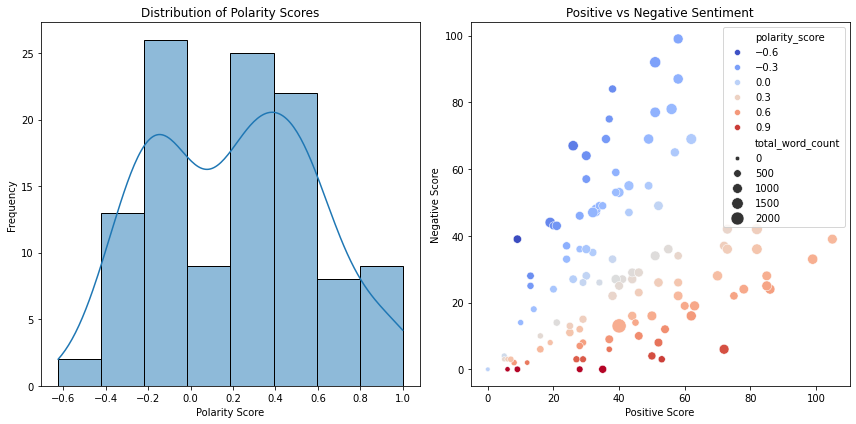

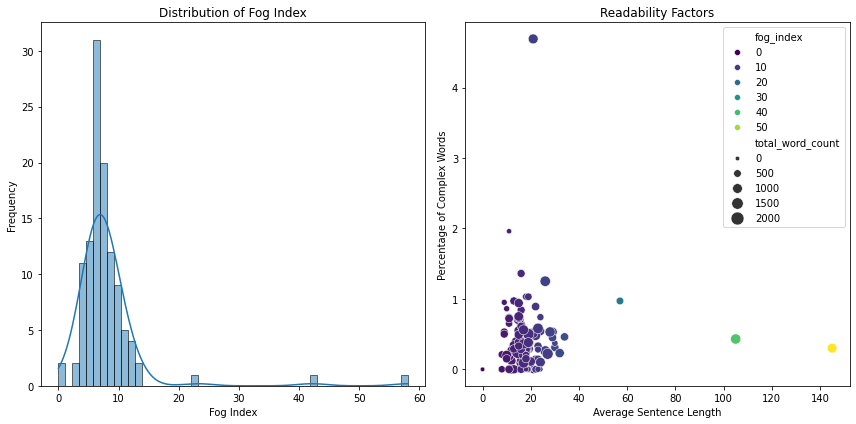

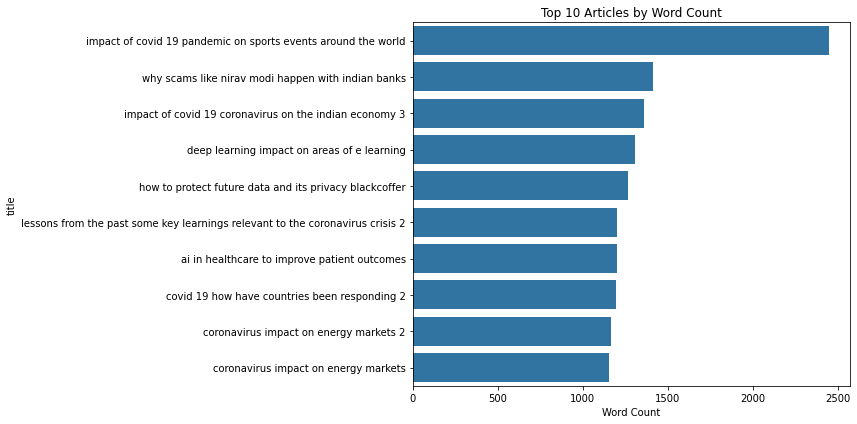

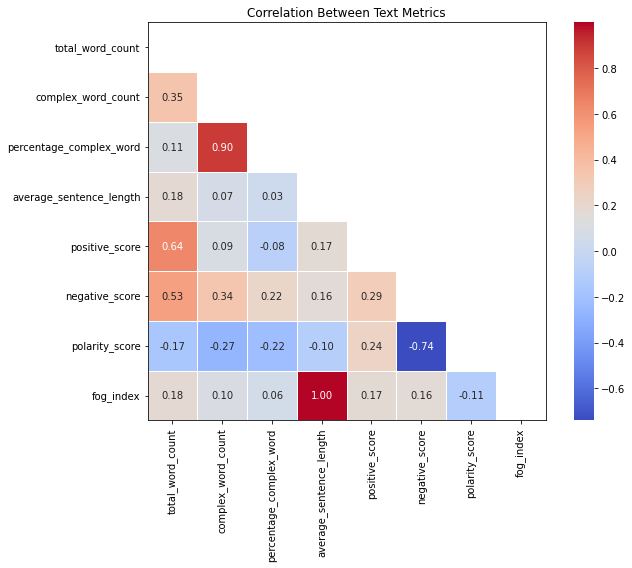

In [43]:
# Data Visualization Section
print("Creating visualizations...")
# Reset to default matplotlib style before creating visualizations
plt.style.use('default')  # Use default style instead of 'ggplot'

# Set a light background and ensure text is visible
plt.rcParams.update({
    'figure.facecolor': 'white',
    'axes.facecolor': 'white',
    'savefig.facecolor': 'white',
    'text.color': 'black',
    'axes.labelcolor': 'black',
    'xtick.color': 'black',
    'ytick.color': 'black'
})

# Custom colormap function to ensure good contrast
def get_readable_cmap(cmap_name):
    """Create a colormap variant that ensures readability on white background"""
    cmap = plt.cm.get_cmap(cmap_name)
    return cmap

# 1. Sentiment Distribution
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(final['polarity_score'], kde=True)
plt.title('Distribution of Polarity Scores')
plt.xlabel('Polarity Score')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.scatterplot(x='positive_score', y='negative_score', hue='polarity_score', 
                palette='coolwarm', size='total_word_count', sizes=(20, 200), data=final)
plt.title('Positive vs Negative Sentiment')
plt.xlabel('Positive Score')
plt.ylabel('Negative Score')
plt.tight_layout()
plt.savefig('sentiment_analysis.png', dpi=300, bbox_inches='tight')

# 2. Readability Metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
sns.histplot(final['fog_index'], kde=True)
plt.title('Distribution of Fog Index')
plt.xlabel('Fog Index')
plt.ylabel('Frequency')

plt.subplot(1, 2, 2)
sns.scatterplot(x='average_sentence_length', y='percentage_complex_word', 
                hue='fog_index', palette='viridis', size='total_word_count', 
                sizes=(20, 200), data=final)
plt.title('Readability Factors')
plt.xlabel('Average Sentence Length')
plt.ylabel('Percentage of Complex Words')
plt.tight_layout()
plt.savefig('readability_analysis.png', dpi=300, bbox_inches='tight')

# 3. Top 10 articles by word count
top_by_words = final.sort_values(by='total_word_count', ascending=False).head(10)
plt.figure(figsize=(12, 6))
sns.barplot(x='total_word_count', y='title', data=top_by_words)
plt.title('Top 10 Articles by Word Count')
plt.xlabel('Word Count')
plt.tight_layout()
plt.savefig('top_articles_by_length.png', dpi=300, bbox_inches='tight')

# 4. Correlation matrix of metrics
plt.figure(figsize=(10, 8))
metrics = ['total_word_count', 'complex_word_count', 'percentage_complex_word', 
           'average_sentence_length', 'positive_score', 'negative_score', 
           'polarity_score', 'fog_index']
corr = final[metrics].corr()
mask = np.triu(np.ones_like(corr, dtype=bool))
heatmap = sns.heatmap(corr, mask=mask, annot=True, fmt='.2f', cmap='coolwarm', 
                     square=True, linewidths=.5)
plt.title('Correlation Between Text Metrics')

# Make sure all ticks are black
for _, spine in heatmap.spines.items():
    spine.set_visible(True)
    spine.set_color('black')

# Make tick labels black
plt.xticks(color='black')
plt.yticks(color='black')
plt.tight_layout()
plt.savefig('metrics_correlation.png', dpi=300, bbox_inches='tight')

In [44]:
# Generate insights summary
print("Generating insights...")

# Calculate some key statistics
avg_polarity = final['polarity_score'].mean()
avg_fog = final['fog_index'].mean()
most_positive = final.loc[final['polarity_score'].idxmax()]
most_negative = final.loc[final['polarity_score'].idxmin()]
most_complex = final.loc[final['fog_index'].idxmax()]
least_complex = final.loc[final['fog_index'].idxmin()]

insights = pd.DataFrame({
    'Metric': ['Average Polarity Score', 'Average Fog Index', 
               'Most Positive Article', 'Most Negative Article',
               'Most Complex Article', 'Least Complex Article'],
    'Value': [f"{avg_polarity:.2f}", f"{avg_fog:.2f}",
              f"{most_positive['title']} (Score: {most_positive['polarity_score']:.2f})",
              f"{most_negative['title']} (Score: {most_negative['polarity_score']:.2f})",
              f"{most_complex['title']} (Fog Index: {most_complex['fog_index']:.2f})",
              f"{least_complex['title']} (Fog Index: {least_complex['fog_index']:.2f})"]
})

# Save insights
insights.to_csv('TextAnalysisInsights.csv', index=False)

Generating insights...


In [45]:
# Export the final results to Excel
final.to_excel('Output.xlsx', index=False)
print("Analysis complete! Results saved to Output.xlsx")

Analysis complete! Results saved to Output.xlsx


In [46]:
# Create a summary visualization dashboard with improved readability
plt.figure(figsize=(15, 10), facecolor='white')

plt.subplot(2, 2, 1)
box = sns.boxplot(data=final[['positive_score', 'negative_score', 'polarity_score']])
plt.title('Sentiment Score Distribution', fontsize=14, color='black')
plt.xlabel('Metrics', color='black')
plt.ylabel('Value', color='black')
plt.grid(True, alpha=0.3)
for text in box.get_xticklabels():
    text.set_color('black')

plt.subplot(2, 2, 2)
box = sns.boxplot(data=final[['average_sentence_length', 'percentage_complex_word', 'fog_index']])
plt.title('Readability Metrics Distribution', fontsize=14, color='black')
plt.xlabel('Metrics', color='black')
plt.ylabel('Value', color='black')
plt.grid(True, alpha=0.3)
for text in box.get_xticklabels():
    text.set_color('black')

plt.subplot(2, 2, 3)
# Get top 5 positive and negative articles
top_positive = final.nlargest(5, 'polarity_score')
top_negative = final.nsmallest(5, 'polarity_score')
combined = pd.concat([top_positive, top_negative])

# Fix the FutureWarning by using hue parameter instead of palette directly
# Using 'polarity_score' as both x and hue, but setting legend to False
bar = sns.barplot(x='polarity_score', y='title', hue='polarity_score', data=combined, palette='RdBu_r', legend=False)
plt.title('Top 5 Most Positive and Negative Articles', fontsize=14, color='black')
plt.xlabel('Polarity Score', color='black')
plt.ylabel('Article Title', color='black')
plt.grid(True, alpha=0.3, axis='x')
# Ensure y-tick labels are readable
for text in bar.get_yticklabels():
    text.set_color('black')

plt.subplot(2, 2, 4)
# Create a white text box with black text for the summary
avg_polarity = final['polarity_score'].mean()
avg_fog = final['fog_index'].mean()
plt.text(0.5, 0.5, f"Text Analysis Summary\n\n"
         f"Total Articles: {len(final)}\n"
         f"Average Polarity: {avg_polarity:.2f}\n"
         f"Average Fog Index: {avg_fog:.2f}\n"
         f"Average Word Count: {final['total_word_count'].mean():.0f}\n",
         horizontalalignment='center',
         verticalalignment='center',
         fontsize=12,
         color='black',
         bbox=dict(facecolor='white', alpha=0.8, boxstyle='round,pad=1', edgecolor='gray'),
         transform=plt.gca().transAxes)
plt.axis('off')

plt.tight_layout()
plt.savefig('analysis_summary.png', dpi=300, bbox_inches='tight', facecolor='white')
plt.close()

print("Generated summary visualizations successfully")

Generated summary visualizations successfully
